kmesh:  [50 50  1]
... kmesh is ready
-3.199990000083333


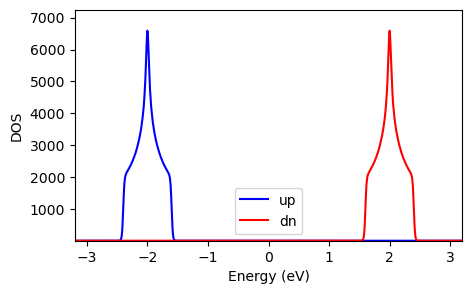

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numba import jit, prange
import time

def kmesh_preparation(kmesh, cell_vec): 
    
    num_kpoints = kmesh[0] * kmesh[1] * kmesh[2]
    rec_vec = np.zeros((3,3))
    k_vec  = np.zeros((num_kpoints,3))

    rec_vec[0]  = (2 * np.pi / np.linalg.det(cell_vec)) * np.cross(cell_vec[1], cell_vec[2])
    rec_vec[1]  = (2 * np.pi / np.linalg.det(cell_vec)) * np.cross(cell_vec[2], cell_vec[0])
    rec_vec[2]  = (2 * np.pi / np.linalg.det(cell_vec)) * np.cross(cell_vec[0], cell_vec[1])

    for q1 in range(kmesh[0]):
        for q2 in range(kmesh[1]):
            for q3 in range(kmesh[2]):
                q = (q1 * kmesh[1] * kmesh[2]) + (q2 * kmesh[2]) + q3
                #to avoid divergence
                if(q1 == 0 and q2 == 0 and q3 == 0):
                    k_vec[q] = (rec_vec[0] * q1/ kmesh[0]) + (rec_vec[1] * q2 / kmesh[1]) + (rec_vec[2] * q3 / kmesh[2]) + np.array([0.01, 0.0, 0.0])
                else:
                    k_vec[q] = (rec_vec[0] * q1/ kmesh[0]) + (rec_vec[1] * q2 / kmesh[1]) + (rec_vec[2] * q3 / kmesh[2])
                
                
                
    print('... kmesh is ready')
    return k_vec 


def energy_contour_preparation(ncol, nrow, e_fermi, e_low, smearing):
    # prepare the energy contour for integration
    num_freq = ncol + 2 * nrow
    de = complex((e_fermi - e_low) / ncol, smearing / nrow)

    E = np.zeros(num_freq, dtype=np.complex128)
    dE = np.zeros(num_freq, dtype=np.complex128)
    e_const = complex(e_low, 0)

    idx_x = 0
    idx_y = 1

    idx = 0
    for i in range(num_freq):
        if (i == nrow):
            idx_x = 1
            idx_y = 0
            idx = 0
            e_const = complex(e_low, smearing)
        elif (i == nrow + ncol):
            idx_x = 0
            idx_y = -1
            idx = 0
            e_const = complex(e_fermi, smearing)
        
        E[i] = e_const + complex(idx * idx_x * (de).real, idx * idx_y * (de).imag)
        dE[i] = complex(idx_x * (de).real, idx_y * (de).imag)
        idx = idx+1

    return E, dE



@jit(nopython=True)
def calc_exchange(index_temp, num_freq, cell_vec, k_vec, E, dE, Ham_K, selfen):
    
    num_kpoints = k_vec.shape[0]
    weight = 1/num_kpoints
 
    corr_greenK = np.zeros(2, dtype=np.complex128)
    r = index_temp[0] * cell_vec[0] + index_temp[1] * cell_vec[1]
    
    exchange = 0.0

    phase = np.zeros((num_kpoints), dtype=np.complex128)
    for e in range(num_kpoints):
        phase[e] = np.exp( 1j * np.dot(k_vec[e],r) )

    for num in range(num_freq):
        delta_i = 0
        greenR_ij = 0
        greenR_ji = 0

        for  e in range(num_kpoints):
            for z in range(2):
                #G = 1/(E - H)
                
                corr_greenK[z] = 1/((E[num] - Ham_K[e, z]) - selfen[z, e, num])  
                
            delta_i += weight * (Ham_K[e, 0] - Ham_K[e, 1] + selfen[0, e, num] - selfen[1, e, num])
            greenR_ij += weight * phase[e] * corr_greenK[1] 
            greenR_ji += weight * np.conj(phase[e]) * corr_greenK[0]
            
        dot_product = delta_i * greenR_ij * delta_i * greenR_ji 
        exchange -= (2/np.pi) * (dot_product * dE[num]).imag
       
    return exchange


@jit(nopython=True)
def calc_green(freq, k_vec, Ham_K, selfen, smearing):
    
    num_kpoints = k_vec.shape[0]
    num_freq = freq.shape[0]
 
    greenR = np.zeros((2, num_kpoints, num_freq), dtype=np.complex128)
    greenR_corr = np.zeros((2, num_kpoints, num_freq), dtype=np.complex128)
    
    for num in range(num_freq):
        for e in range(num_kpoints):
            for z in range(2):
                #G = 1/(E - H)
                greenR[z, e, num] += 1/(freq[num] - Ham_K[e, z] + 1j*smearing)
                greenR_corr[z, e, num] += 1/((freq[num] - Ham_K[e, z]) - selfen[z, e, num])
        
    greenR *= -(1/np.pi) 
    greenR_corr *= -(1/np.pi)
    
    return greenR, greenR_corr

        
    
    
def cal_el_k(t, delta, e_fermi, cell_vec, k_vec): 
    
    num_kpoints = k_vec.shape[0]
    el_k = np.zeros((num_kpoints, 2), dtype=np.complex128)
    Ham_r = np.zeros((3, 3, 2))
    
    # nn hopping t 
    Ham_r[0, 1, 0] = t
    Ham_r[1, 0, 0] = t
    Ham_r[1, 2, 0] = t
    Ham_r[2, 1, 0] = t
    
    Ham_r[0, 1, 1] = t
    Ham_r[1, 0, 1] = t
    Ham_r[1, 2, 1] = t
    Ham_r[2, 1, 1] = t
    
    Ham_r[1, 1, 0] = -0.5 * delta - e_fermi # spin_up
    Ham_r[1, 1, 1] =  0.5 * delta - e_fermi # spin_dn
    
    #vectorized version of Fourier transform
    for i in range(-1, 2):
        for j in range(-1, 2):
            r = i * cell_vec[0] + j * cell_vec[1]
            k_dot_r = (k_vec @ r).reshape(num_kpoints, 1)
            phase = np.exp(-1j * k_dot_r)
            el_k += phase * Ham_r[i + 1, j + 1, :]
            
    return el_k



def cal_ph_q(v, k_vec):
    num_kpoints = k_vec.shape[0]
    ph_q = np.zeros((num_kpoints, 2))
    
    v = v * 0.658e-5 #(eV*s/m) 
    
    for q in range(num_kpoints):
        q_abs = np.linalg.norm(k_vec[q])
        ph_q[q, 0] = v * q_abs # (v * \hbar q) acoustic mode 
        ph_q[q, 1] = v * q_abs # (v * \hbar q) acoustic mode 
        
    return ph_q 



@jit(nopython=True, parallel=True)
def elph_selfen(g, kT, kmesh, freq, el_k, ph_q):
    
    def bose(kT, E):
        return 1.0 / (np.exp(E / kT) - 1)

    def fermi(kT,E):
#         return np.where(E.real < 0, 1.0, 0.0) + 0j  # step function
        return 1 / (np.exp(E / kT) + 1)

    num_freq = freq.shape[0]
    num_kpoints = kmesh[0] * kmesh[1]

    selfen = np.zeros((2, num_kpoints, num_freq), dtype=np.complex128)
    weight = 1 / num_kpoints
    
    delta = 0.005 # 50K

    el_k = el_k.reshape(kmesh[0], kmesh[1], 2)
    ph_q = ph_q.reshape(kmesh[0], kmesh[1], 2)

    for k1 in prange(kmesh[0]):
        for k2 in prange(kmesh[1]):
            k = k2 + (k1 * kmesh[1])
            for q1 in range(kmesh[0]):
                for q2 in range(kmesh[1]):
                    kq1 = (k1 + q1) % kmesh[0]
                    kq2 = (k2 + q2) % kmesh[1]

                    for z in range(2):
                        bose_term = bose(kT, ph_q[q1, q2, z])
                        fermi_term = fermi(kT, el_k[kq1, kq2, z])
                        el_energy = el_k[kq1, kq2, z]
                        ph_energy = ph_q[q1, q2, z]
                    
                        for w in range(num_freq):
                            selfen[z, k, w] += (bose_term + fermi_term) / (freq[w] - el_energy + ph_energy + 1j*delta) + \
                            (bose_term + 1 - fermi_term) / (freq[w] - el_energy - ph_energy + 1j*delta) 


    selfen *= g * weight
    
    if(np.any(np.isnan(selfen))):
        print("There is a divergence!!!")
    
    return selfen  


@jit(nopython=True)    
def plot_dos(freq, energy_k):
    
    def dirac_delta(kT,E_tot):
        E = E_tot.real
        if(np.abs(E/kT) < 20):
            delta = (np.exp(E/kT)/kT)/(1 + np.exp(E/kT))**2
        else:
            delta = 0
        return delta
    
    num_kpoints = energy_k.shape[0]
    num_enpoints = freq.shape[0]
    dos_F = np.zeros((1000, 2))
    kT = 0.01
    
    for spin in range(2):
        for en in range(1000):
            for k in range(num_kpoints):        
                dos_F[en, spin] += dirac_delta(kT, freq[en] - energy_k[k, spin])
                
        dos_F[en, spin] = dos_F[en, spin]/num_kpoints 
        
    return dos_F

#############################################################################

t = -0.1 # hopping (in eV)
delta = 4 # spin splitting (in eV)
e_fermi = 0 # Fermi energy
smearing = 0.01 # smearing for integration

ncol = 600
nrow = 300
num_freq = ncol + 2 * nrow 

kmesh = np.array([50, 50, 1])
num_kpoints = np.prod(kmesh)
print('kmesh: ', kmesh)

cell_vec = np.array([[1.0,  0.0, 0.0],
                     [0.0,  1.0, 0.0],
                     [0.0,  0.0, 10.0]])



k_vec = kmesh_preparation(kmesh, cell_vec)
el_k = cal_el_k(t, delta, e_fermi, cell_vec, k_vec)

e_low = np.min(el_k.real) - 0.2*delta # min energy for integration
e_max = -e_low
print(e_low)

en_line = np.linspace(e_low, e_max, 1000)
dos = plot_dos(en_line, el_k)

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
ax.plot(en_line, dos[:, 0], color='Blue', label='up') 
ax.plot(en_line, dos[:, 1], color='Red', label='dn') 
ax.set_xlim(np.min(en_line), np.max(en_line))
ax.set_ylim(0.1, np.max(dos) + 0.1 * np.max(dos))
ax.legend()
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('DOS')

results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

fig.savefig(os.path.join(results_dir, 'el_DOS.png'), dpi=300, facecolor='w', transparent=False, bbox_inches='tight')

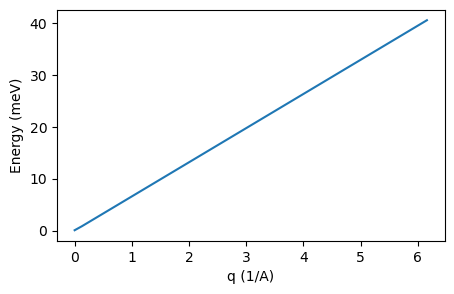

In [3]:
v = 1000 # sound velocity (in m/c)
ph_q = cal_ph_q(v, k_vec)
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
ax.plot(k_vec[:kmesh[0],1], 1000 * ph_q[:kmesh[0], 0])
ax.set_xlabel('q (1/A)')
ax.set_ylabel('Energy (meV)')
fig.savefig(os.path.join(results_dir, 'ph_dispertion.png'), dpi=300, facecolor='w', transparent=False, bbox_inches='tight')

0.00010150227831282994 31.83098717065025
2.99888879353173e-08 102.83609375735199


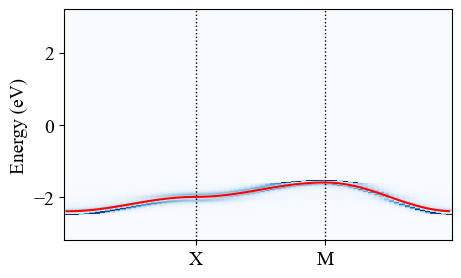

In [4]:
#extract dispersion along G - X - M - G
el_k_new = el_k.reshape(kmesh[0], kmesh[1], 2).real

shift_x = int(0.5 * kmesh[0])
shift_y = int(0.5 * kmesh[1])

num_points = kmesh[0] + shift_y
disp_el = np.zeros(num_points)

for i in range(num_points):
    if(i <= shift_x):
        disp_el[i] = el_k_new[i, 0, 0].real
        
    elif(i > shift_x and i < shift_x + shift_y):
        disp_el[i] = el_k_new[shift_x, i - shift_x, 0]
        
    else:
        disp_el[i] = el_k_new[shift_x - i, shift_y - i, 0]
 

###########
g = 0.01
T = 150
selfen = elph_selfen(g, T*0.00008617, kmesh, en_line, el_k, ph_q)
green, green_corr = calc_green(en_line, k_vec, el_k, selfen, smearing)
print(np.min(green[0].imag), np.max(green[0].imag))
print(np.min(green_corr[0].imag), np.max(green_corr[0].imag))
############


plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams.update({'font.size': 14})
from mpl_toolkits.axes_grid1 import make_axes_locatable

spectral_el = np.zeros((num_points, en_line.shape[0]))
green_corr_new = green_corr.reshape(2, kmesh[0], kmesh[1], en_line.shape[0])

for i in range(num_points):
    if(i <= shift_x):
        spectral_el[i] = green_corr_new[0, i, 0].imag
        
    elif(i > shift_x and i < shift_x + shift_y):
        spectral_el[i] = green_corr_new[0, shift_x, i - shift_x].imag
        
    else:
        spectral_el[i] = green_corr_new[0, shift_x - i, shift_y - i].imag
   

xmesh, ymesh = np.meshgrid(np.arange(num_points), en_line)

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
ax.pcolor(xmesh, ymesh, spectral_el.T, shading='auto', cmap='Blues', vmin=0, vmax=10)
ax.plot(disp_el, color='Red')
ax.set_ylabel('Energy (eV)')
ax.set_xticks([shift_x, kmesh[0]])
ax.set_xticklabels(['X', 'M'])
ax.grid(color='black', linestyle='dotted', linewidth=1, axis='x')
fig.savefig(os.path.join(results_dir, 'spectral_function.png'), dpi=400, facecolor='w', transparent=False, bbox_inches='tight')

In [5]:
# bare exchange interaction without electron-phonon
freq = np.linspace(e_low, e_fermi, ncol)

index_temp = np.array([1, 0])
E, dE = energy_contour_preparation(ncol, nrow, e_fermi, e_low, smearing)

g = 0
T = 10
selfen = np.zeros((2, num_kpoints, num_freq), dtype=np.complex128)
J = calc_exchange(index_temp, num_freq, cell_vec, k_vec, E, dE, el_k, selfen)
print(J)

0.010230796503673133


In [ ]:
v = np.linspace(300, 3000, 10) # sound velocity (in m/c)
T = np.linspace(10, 300, 10)
data = np.zeros((10,10), dtype=np.float64)

for i in range(10):
    for j in range(10):
        ph_q = cal_ph_q(v[i], k_vec)
        selfen = elph_selfen(0.03, T[j]*0.00008617, kmesh, freq, el_k, ph_q)
        selfen = np.pad(selfen, [(0, 0), (0, 0),(nrow, nrow)])
        J = calc_exchange(index_temp, num_freq, cell_vec, k_vec, E, dE, el_k, selfen)
        data[i, j] = J
        print(i, j, J)
    
print('Done!')

There is a divergence!!!
0 0 nan
0 1 0.010337858638451155
0 2 0.010408130916472465
0 3 0.010481644097466164
0 4 0.01055734979965683
0 5 0.0106364898302337
0 6 0.01071564199533859
0 7 0.010799156476990604
0 8 0.010881288869324268
0 9 0.010967859385953314
There is a divergence!!!
1 0 nan
1 1 0.010297320469479601
1 2 0.010327795001818213
1 3 0.010361308498084195
1 4 0.010396868241398332
1 5 0.010433596439623556
1 6 0.010471228589758068
1 7 0.010507351012957702
1 8 0.010545327306541383
1 9 0.01058458790563643
There is a divergence!!!
2 0 nan
2 1 0.010285526483206978
2 2 0.010303526160863686
2 3 0.010323557268796265
2 4 0.010345927908482107
2 5 0.010368932024753134
2 6 0.010393187736396334
2 7 0.010417353060888895
2 8 0.01044164658407244
2 9 0.010464997028793244
There is a divergence!!!
3 0 nan
3 1 0.010281863039301802
3 2 0.010294067775800811
3 3 0.010308234325268513
3 4 0.01032355314035577
3 5 0.010339031040064377
3 6 0.01035473167971922
3 7 0.010371683138090015
3 8 0.010389168202334563
3

In [ ]:
xmesh, ymesh = np.meshgrid(T, v)
fig = plt.figure(figsize=(5,5))
ax = plt.subplot()
im = ax.pcolor(xmesh, ymesh, data.T, shading='auto', cmap='inferno', vmin=5, vmax=70)
ax.contour(xmesh, ymesh, data.T, levels=6, colors='black', linewidths=0.5, linestyles='dashed')
ax.set_xlabel('T (K)')
ax.set_ylabel('v (m/c)')
# ax.set_xticks([60, 120, 180, 240, 300])
# ax.set_yticks([1000, 1500, 2000, 2500, 3000])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
fig.savefig('phase_diagram.png', dpi=300, facecolor='w', transparent=False, bbox_inches='tight')
fig.savefig(os.path.join(results_dir, 'phase_diagram.png'), dpi=400, facecolor='w', transparent=False, bbox_inches='tight')

In [ ]:
with open("J_plot.dat", "w") as fp:
    for i in range(10):
        print('{0.real:.4f}'.format(T[i]),'  '.join('{0.real:.4f}'.format(item) for item in data[:,i]), file=fp)